In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa as tsm
from statsmodels.formula.api import ols
from astsadata import *

/mnt/d/work/tsa4-python/.venv/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [2]:
def acf1(x, nlags=None, acf_type="correlation", pacf=False, ax=None, **kwargs):
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == "correlation":
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = "PACF"
    else:
        if acf_type == "correlation":
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = "ACF"
        elif acf_type == "covariance":
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = "ACoV"

    if ax is None:
        ax = plt.gca()
 
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    if acf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

# Section 3.8 Regression with Autocorrelated Errors

In [3]:
# Example 3.44
trend = pd.Series([idx.ordinal for idx in cmort.index], index=cmort.index)
temp = tempr - tempr.mean()
temp2 = temp**2
reg_data = pd.concat([trend, temp, temp2, part], axis=1)
reg_data.columns = ["trend", "temp", "temp2", "part"]

fit = ols("cmort ~ trend + temp + temp2 + part", data=reg_data).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  cmort   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     185.1
Date:                Tue, 18 May 2021   Prob (F-statistic):           2.20e-97
Time:                        12:37:02   Log-Likelihood:                -1660.1
No. Observations:                 508   AIC:                             3330.
Df Residuals:                     503   BIC:                             3351.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.5931      1.102     74.032      0.0

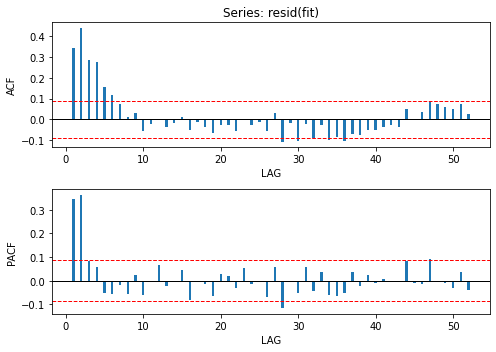

In [4]:
fig, axes = plt.subplots(nrows=2, figsize=(7, 5))

acf1(fit.resid, nlags=52, ax=axes[0], width=.3)
axes[0].set_title("Series: resid(fit)")

acf1(fit.resid, nlags=52, pacf=True, ax=axes[1], width=.3)
 
fig.tight_layout()
plt.show()

In [5]:
fit = sm.tsa.SARIMAX(cmort, reg_data.loc[:, reg_data.columns != "cmort"], order=(2, 0, 0)).fit()
print(fit.summary())
# The coefficients are a bit different to the ones of R.
# Perhaps, different defaults. 

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  508
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1569.789
Date:                Tue, 18 May 2021   AIC                           3153.579
Time:                        12:37:03   BIC                           3183.192
Sample:                    01-04-1970   HQIC                          3165.191
                         - 10-07-1979                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.1985      0.057      3.472      0.001       0.086       0.311
temp           0.0485      0.044      1.107      0.268      -0.037       0.134
temp2          0.0170      0.002      8.704      0.0

/mnt/d/work/tsa4-python/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/mnt/d/work/tsa4-python/.venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


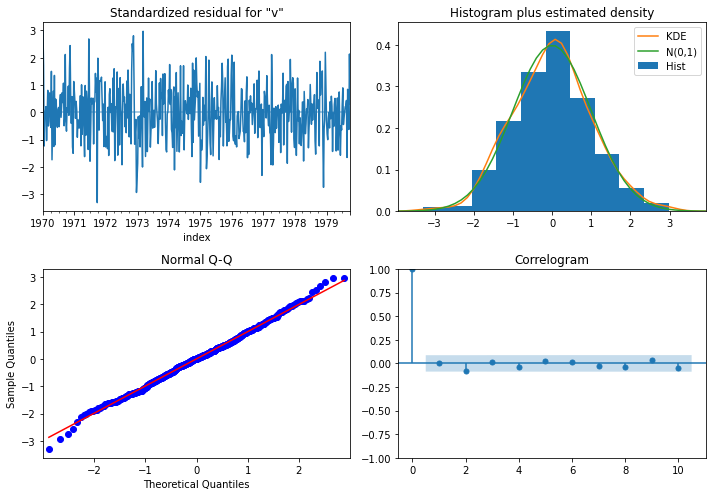

In [6]:
fig = fit.plot_diagnostics(figsize=(10, 7))
fig.tight_layout()
plt.show()

In [7]:
# Example 3.45
# Note: this could benefit from a seasonal model fit, but it hasn't
# been talked about yet - you could come back to this after the next section
dummy = pd.Series(np.where(soi.iloc[:, 0] < 0, 0, 1), index=soi.index)
fish = pd.concat([rec, soi.shift(6), dummy.shift(6)], axis=1).dropna()
fish.columns = ["rec", "soiL6", "dL6"]

fit = ols("rec ~ soiL6 * dL6", data=fish).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    rec   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     99.43
Date:                Tue, 18 May 2021   Prob (F-statistic):           3.20e-49
Time:                        12:37:05   Log-Likelihood:                -2010.7
No. Observations:                 447   AIC:                             4029.
Df Residuals:                     443   BIC:                             4046.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.4794      2.865     25.998      0.0

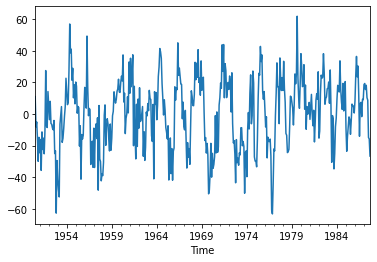

In [8]:
fit.resid.plot(xlabel="Time")
plt.show()

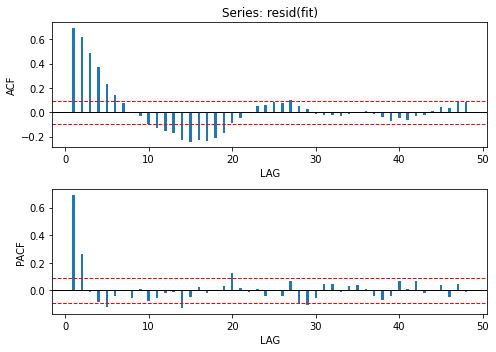

In [9]:
fig, axes = plt.subplots(nrows=2, figsize=(7, 5))

acf1(fit.resid, nlags=48, ax=axes[0], width=.3)
axes[0].set_title("Series: resid(fit)")

acf1(fit.resid, nlags=48, pacf=True, ax=axes[1], width=.3)

fig.tight_layout()
plt.show()

In [10]:
fish.loc[:, "intract"] = fish.loc[:, "soiL6"] * fish.loc[:, "dL6"]
fit = sm.tsa.SARIMAX(fish.loc[:, "rec"], fish.loc[:, fish.columns != "rec"], order=(2, 0, 0)).fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    rec   No. Observations:                  447
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1652.120
Date:                Tue, 18 May 2021   AIC                           3316.240
Time:                        12:37:06   BIC                           3340.855
Sample:                    07-31-1950   HQIC                          3325.945
                         - 09-30-1987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
soiL6          7.5289      2.309      3.260      0.001       3.003      12.055
dL6           -2.4440      0.966     -2.531      0.011      -4.337      -0.551
intract       -9.6710      2.808     -3.444      0.0

/mnt/d/work/tsa4-python/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/mnt/d/work/tsa4-python/.venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


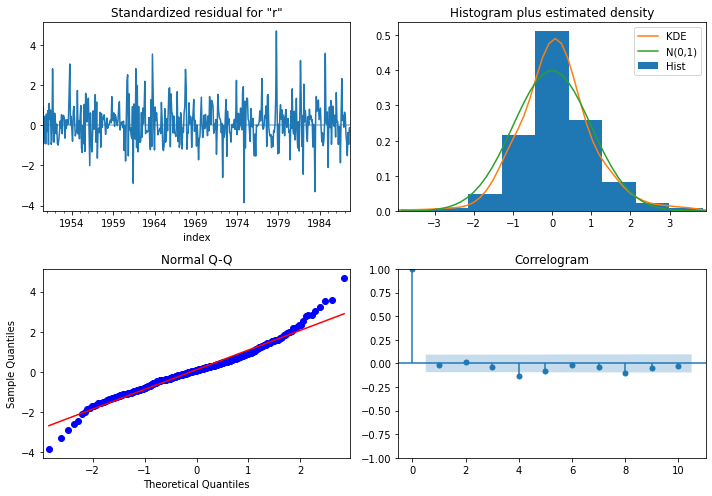

In [11]:
fig = fit.plot_diagnostics(figsize=(10, 7))
fig.tight_layout()
plt.show()